# EE675A: Assignment 3

**Name**: Avinash Shukla                            </br>
**Roll No.**: 210236


#### Question - 1

$$
%\begin{flalign}
 \pi(A_{t} | S_{t}, \theta) = \text{softmax}(\theta^T . S) \\
 = \frac{1}{e^{\theta_{1}^T . S} + e^{\theta_{2}^T . S}}\begin{bmatrix}
e^{\theta_{1}^T . S} \\
e^{\theta_{2}^T . S}
\end{bmatrix}
\\
=
\begin{bmatrix}
\frac{e^{\theta_{1}^T . S}}{e^{\theta_{1}^T . S} + e^{\theta_{2}^T . S}} \\ \\
\frac{e^{\theta_{2}^T . S}}{e^{\theta_{1}^T . S} + e^{\theta_{2}^T . S}}
\end{bmatrix}
 %\end{flalign}
 $$



$$
%\begin{flalign}
\implies ln(\pi(A_{t} | S_{t}, \theta)) = \begin{bmatrix}
ln(\frac{e^{\theta_{1}^T . S}}{e^{\theta_{1}^T . S} + e^{\theta_{2}^T . S}}) \\ \\
ln(\frac{e^{\theta_{2}^T . S}}{e^{\theta_{1}^T . S} + e^{\theta_{2}^T . S}})
\end{bmatrix} \\ \\
= \begin{bmatrix}
\theta_{1}^T . S - ln(e^{\theta_{1}^T . S} + e^{\theta_{2}^T . S})\\
\theta_{2}^T . S - ln(e^{\theta_{1}^T . S} + e^{\theta_{2}^T . S})
\end{bmatrix}
%\end{flalign}
$$

$$
%\begin{flalign}
\implies \nabla_{\theta} ln(\pi(A_{t} | S_{t}, \theta)) = 
\begin{bmatrix}
S^T - \frac{e^{\theta_{1}^T . S}}{e^{\theta_{1}^T . S} + e^{\theta_{2}^T . S}} . S^T\\
S^T - \frac{e^{\theta_{2}^T . S}}{e^{\theta_{1}^T . S} + e^{\theta_{2}^T . S}} . S^T
\end{bmatrix}  \\ \\
= 
\begin{bmatrix}
S^T - \text{softmax}(\theta_1^T . S) .S^T\\
S^T - \text{softmax}(\theta_2^T . S) .S^T
\end{bmatrix}
%\end{flalign}
$$

 


In [69]:
import gymnasium as gym   # gymnasium package, in order to simulate the cart-pole environment
# import matplotlib     # Matplotlib package to plot the various graphs
import numpy as np   # numpy package to use arrays and mathematical functions
from matplotlib import pyplot as plt

In [70]:
import numpy as np

class REINFORCE_Agent:
    def __init__(self, env, alpha=2.5, num_episodes=1000, discount_factor=0.9):
        self.env = env
        self.alpha = alpha
        self.num_episodes = num_episodes
        self.discount_factor = discount_factor
        self.theta = np.random.rand(2, 4)

    def ret_action(self, policy):
        num = np.random.uniform(low=0, high=1)
        if num < policy[0]:
            return 0  # Taking the action to go left
        else:
            return 1  # taking the action to go right

    def ret_policy(self, t, s):
        s = s.reshape(4, 1)
        t = np.dot(t, s)
        t = t.reshape(2,)
        t = t - np.max(t)
        e = np.exp(t)
        d = np.sum(e)
        soft = e / d
        return soft

    def gradient(self, t, s):
        return (1 - t)[:, np.newaxis] * s

    def values(self):
        rewards = []
        for _ in range(5):
            reward = 0
            init_state, _ = self.env.reset()
            policy = self.ret_policy(self.theta, init_state)
            done, cross = False, False
            i = 0
            while (not done and not cross) and i <= 500:
                i += 1
                act = self.ret_action(policy)
                observation, r, done, cross, _ = self.env.step(act)
                reward += r
                policy = self.ret_policy(self.theta, observation)
            rewards.append(reward)
        total_reward = np.sum(rewards)
        av_reward = total_reward / 5
        return av_reward

    def train(self):
        Returns = []
        eps = []
        for episode_num in range(self.num_episodes):
            eps.append(episode_num + 1)
            action = np.empty(0)
            reward = []
            states = np.empty((0, 4))
            init_state, _ = self.env.reset()
            states = np.append(states, [init_state], axis=0)
            pol = self.ret_policy(self.theta, init_state)
            done, cross = False, False
            while (not done and not cross):
                act = self.ret_action(pol)
                action = np.append(action, act)
                observation, r, done, cross, _ = self.env.step(act)
                states = np.append(states, [observation], axis=0)
                reward.append(r)
                pol = self.ret_policy(self.theta, observation)
            
            Returns.append(np.sum(reward))
            
            for k in range(len(reward)):
                G = 0
                dis_fac = 1
                for r in reward[k:]:
                    x = dis_fac * r
                    dis_fac *= self.discount_factor
                    G += x
                pol = self.ret_policy(self.theta, states[k])
                grads = self.gradient(pol, states[k])
                self.theta += self.alpha * pow(self.discount_factor, k) * G * grads
        
        plt.plot(eps, Returns)
        plt.xlabel('Episode Number')
        plt.ylabel('Episode Returns')
        plt.title('Episode Returns vs Episode Number')
        plt.show()
        print("Rewards in the REINFORCE Algo:", self.values())




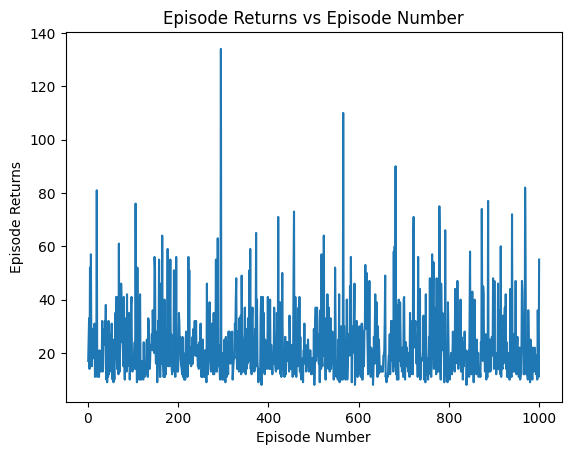

Rewards in the REINFORCE Algo: 25.8


In [71]:
env = gym.make('CartPole-v1')
env.reset()

agent = REINFORCE_Agent(env)
agent.train()

In [72]:
import numpy as np

class REINFORCE_baseline_Agent:
    def __init__(self, env):
        self.env = env
        self.params = np.random.rand(4,2)
        self.baseline = np.zeros((4,1))
        self.gamma = 0.99
        self.alpha_params = 0.01
        self.alpha_baseline = 0.01

    def policy(self, state):
        return np.exp(np.dot(self.params.T, state))/np.sum(np.exp(np.dot(self.params.T, state)))
    
    def get_action(self, state):
        return np.random.choice([0,1], p=self.policy(state))
    
    def play_episode(self):
        state, _ = self.env.reset()
        states, actions, rewards = [], [], []
        done = False
        trunc = False
        while not (done or trunc) :
            action = self.get_action(state)
            states.append(state)
            actions.append(action)
            state, reward, done, trunc,_ = self.env.step(action)
            rewards.append(reward)
        return states, actions, rewards
    
    def param_gradient(self, state, action):
        grad = np.zeros((4, 2))
        product = np.dot(state, self.params)
        c = np.sum(np.exp(product))

        if action == 0: 
            grad[:, 0] = state * (1 - np.exp(product[0]) / c)
            grad[:, 1] = -state * np.exp(product[1]) / c
        else:
            grad[:, 0] = -state * np.exp(product[0]) / c
            grad[:, 1] = state * (1 - np.exp(product[1]) / c)

        return grad
    
   
    def update_parameters(self, states, actions, rewards):
        G = 0
        I = 1
        for t in range(-1,-len(states),-1):
            G = self.gamma*G + rewards[t]
            TD = G - np.dot(self.baseline.T, states[t])
            self.baseline += self.alpha_baseline*TD*states[t].reshape(4,1)
            self.params += self.alpha_params*TD*I*self.param_gradient(states[t],actions[t])
            I *= self.gamma
        return
    
    def train(self, n_episodes):
        for i in range(n_episodes):
            states, actions, rewards = self.play_episode()
            self.update_parameters(states, actions, rewards)
            if i%100==0:
                print(i)
        return

        

0
100
200
300
400
500
600
700
800
900


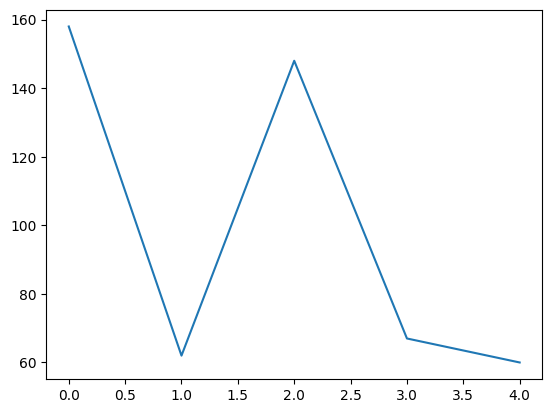

Rewards in the REINFORCE with baseline Algo:


(99.0, 44.26285124119322)

In [73]:
B = REINFORCE_baseline_Agent(env)
B.train(1000)
rewards = []
for i in range(5):
    _,__,r = B.play_episode()
    rewards.append(sum(r))
plt.figure()
plt.plot(rewards)
plt.show()
print("Rewards in the REINFORCE with baseline Algo:")
np.average(rewards), np.std(rewards)